In [1]:
import os
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
import anndata as ad
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy import stats
from scipy.stats import spearmanr, pearsonr
import lamindb as ln
from modlyn.io.loading import read_lazy
from modlyn.io.datamodules import ClassificationDataModule
from modlyn.models.linear import Linear
import lightning as L

# Set up scanpy settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

→ connected lamindb: laminlabs/arrayloader-benchmarks


In [11]:
# =============================================================================
# STEP 1: Create Clean 100k Subset (Reproducible)
# =============================================================================

# def create_clean_subset(store_path, var_file, n_cells=100000, seed=42):
#     """Create a clean, balanced subset of the data"""
#     print("Loading full dataset...")
#     adata_full = read_lazy(store_path)
#     var = pd.read_parquet(var_file)
#     adata_full.var = var
    
#     np.random.seed(seed)
#     cell_lines = adata_full.obs['cell_line'].unique()
#     n_per_line = n_cells // len(cell_lines)
    
#     print(f"Creating subset with {n_per_line} cells per line from {len(cell_lines)} cell lines")
    
#     subset_indices = []
#     for cell_line in cell_lines:
#         mask = adata_full.obs['cell_line'] == cell_line
#         indices = np.where(mask)[0]
#         if len(indices) >= n_per_line:
#             selected = np.random.choice(indices, n_per_line, replace=False)
#             subset_indices.extend(selected)
    
#     adata = adata_full[subset_indices].copy()
#     print(f"Clean subset: {adata.n_obs} cells, {adata.n_vars} genes")
#     print(f"Cell lines: {adata.obs['cell_line'].value_counts()}")
    
#     return adata

# # Create the subset
# store_path = Path("/home/ubuntu/tahoe100M_chunk_1")
# adata = create_clean_subset(store_path, "var_subset_tahoe100M.parquet", n_cells=1000)
# adata


def create_clean_subset(store_path, var_file, n_cells=100000, n_genes=5000, seed=42):
    """Create a clean, balanced subset of the data with random gene selection"""
    print("Loading full dataset...")
    adata_full = read_lazy(store_path)
    var = pd.read_parquet(var_file)
    adata_full.var = var
    
    np.random.seed(seed)
    
    # First subset cells
    cell_lines = adata_full.obs['cell_line'].unique()
    n_per_line = n_cells // len(cell_lines)
    
    print(f"Creating subset with {n_per_line} cells per line from {len(cell_lines)} cell lines")
    
    subset_indices = []
    for cell_line in cell_lines:
        mask = adata_full.obs['cell_line'] == cell_line
        indices = np.where(mask)[0]
        if len(indices) >= n_per_line:
            selected = np.random.choice(indices, n_per_line, replace=False)
            subset_indices.extend(selected)
    
    adata = adata_full[subset_indices].copy()
    
    # Random gene subset
    print(f"Randomly selecting {n_genes} genes...")
    gene_indices = np.random.choice(adata.n_vars, size=min(n_genes, adata.n_vars), replace=False)
    adata = adata[:, gene_indices].copy()
    
    print(f"Clean subset: {adata.n_obs} cells, {adata.n_vars} genes")
    print(f"Cell lines: {adata.obs['cell_line'].value_counts()}")
    
    return adata

# Create the subset
store_path = Path("/home/ubuntu/tahoe100M_chunk_1")
adata = create_clean_subset(store_path, "var_subset_tahoe100M.parquet", n_cells=1000, n_genes=5000)
adata

Loading full dataset...


/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/zarr/codecs/vlen_ut

Creating subset with 20 cells per line from 50 cell lines
Randomly selecting 5000 genes...
Clean subset: 1000 cells, 5000 genes
Cell lines: cell_line
CVCL_0023    20
CVCL_0028    20
CVCL_0069    20
CVCL_0099    20
CVCL_0131    20
CVCL_0152    20
CVCL_0179    20
CVCL_0218    20
CVCL_0292    20
CVCL_0293    20
CVCL_0320    20
CVCL_0332    20
CVCL_0334    20
CVCL_0359    20
CVCL_0366    20
CVCL_0371    20
CVCL_0397    20
CVCL_0399    20
CVCL_0428    20
CVCL_0459    20
CVCL_0480    20
CVCL_0504    20
CVCL_0546    20
CVCL_1055    20
CVCL_1056    20
CVCL_1094    20
CVCL_1097    20
CVCL_1098    20
CVCL_1119    20
CVCL_1125    20
CVCL_1239    20
CVCL_1285    20
CVCL_1381    20
CVCL_1478    20
CVCL_1495    20
CVCL_1517    20
CVCL_1531    20
CVCL_1547    20
CVCL_1550    20
CVCL_1571    20
CVCL_1577    20
CVCL_1635    20
CVCL_1666    20
CVCL_1693    20
CVCL_1715    20
CVCL_1716    20
CVCL_1717    20
CVCL_1724    20
CVCL_1731    20
CVCL_C466    20
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 1000 × 5000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate'

In [13]:
# =============================================================================
# STEP 2: Scanpy Differential Expression
# =============================================================================

def run_scanpy_analysis(adata, n_genes=50):
    """Run scanpy differential expression analysis"""
    print("Running Scanpy analysis...")
    
    # Prepare data
    adata_scanpy = adata.copy()
    adata_scanpy.X = adata_scanpy.X.compute()
    if hasattr(adata_scanpy.X, 'toarray'):
        adata_scanpy.X = adata_scanpy.X.toarray()
    
    # Normalize and log transform
    sc.pp.normalize_total(adata_scanpy, target_sum=1e4)
    sc.pp.log1p(adata_scanpy)
    
    # Run differential expression
    sc.tl.rank_genes_groups(adata_scanpy, 'cell_line', method='wilcoxon', n_genes=n_genes)
    
    scanpy_results = {}
    for cell_line in adata_scanpy.obs['cell_line'].cat.categories:
        genes_df = sc.get.rank_genes_groups_df(adata_scanpy, group=cell_line)
        scanpy_results[cell_line] = genes_df.set_index('names')
    
    return adata_scanpy, scanpy_results

adata_scanpy, scanpy_results = run_scanpy_analysis(adata)

Running Scanpy analysis...
normalizing counts per cell
    finished (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: Performanc

In [14]:
# =============================================================================
# STEP 3: Modlyn
# =============================================================================

def run_modlyn_analysis(adata, n_epochs=5, n_genes=50):
    """Run modlyn logistic regression analysis"""
    print("Running Modlyn analysis...")
    
    # Prepare data
    modlyn_adata = adata.copy()
    modlyn_adata.obs["y"] = modlyn_adata.obs["cell_line"].astype("category").cat.codes.to_numpy().astype("i8")
    
    # Train/val split
    n_train = int(0.8 * modlyn_adata.n_obs)
    adata_train = modlyn_adata[:n_train]
    adata_val = modlyn_adata[n_train:]
    
    # Create datamodule
    datamodule = ClassificationDataModule(
        adata_train=adata_train,
        adata_val=adata_val,
        label_column="y",
        train_dataloader_kwargs={"batch_size": 1024, "drop_last": True},
        val_dataloader_kwargs={"batch_size": 1024, "drop_last": False},
    )
    
    # Train model
    linear = Linear(
        n_genes=modlyn_adata.n_vars,
        n_covariates=modlyn_adata.obs["y"].nunique(),
        learning_rate=1e-3,
    )
    
    trainer = L.Trainer(max_epochs=n_epochs, log_every_n_steps=50, enable_progress_bar=True)
    trainer.fit(linear, datamodule)
    
    weights = linear.linear.weight.detach().cpu().numpy()
    cell_line_names = modlyn_adata.obs['cell_line'].cat.categories
    
    modlyn_results = {}
    for i, cell_line in enumerate(cell_line_names):
        weights_series = pd.Series(weights[i], index=modlyn_adata.var_names)
        top_genes = weights_series.abs().nlargest(n_genes)
        
        modlyn_results[cell_line] = pd.DataFrame({
            'weight': weights_series[top_genes.index],
            'abs_weight': top_genes,
            'logfoldchange': weights_series[top_genes.index],  # For compatibility
            'pvals_adj': np.ones(len(top_genes)) * 0.05,  # Placeholder
        })
    
    return modlyn_adata, modlyn_results

modlyn_adata, modlyn_results = run_modlyn_analysis(adata, n_epochs=1)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


Running Modlyn analysis...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | linear        | Linear           | 250 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
250 K     Trainable params
0         Non-trainable params
250 K     Total params
1.000     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                                                    | 0/? [00:00<?, ?it/s]

/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:106: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:106: Total length of `CombinedLoader` across ranks is zero. Please make sure this was your intention.
`Trainer.fit` stopped: No training batches.


normalizing counts per cell
    finished (0:00:00)


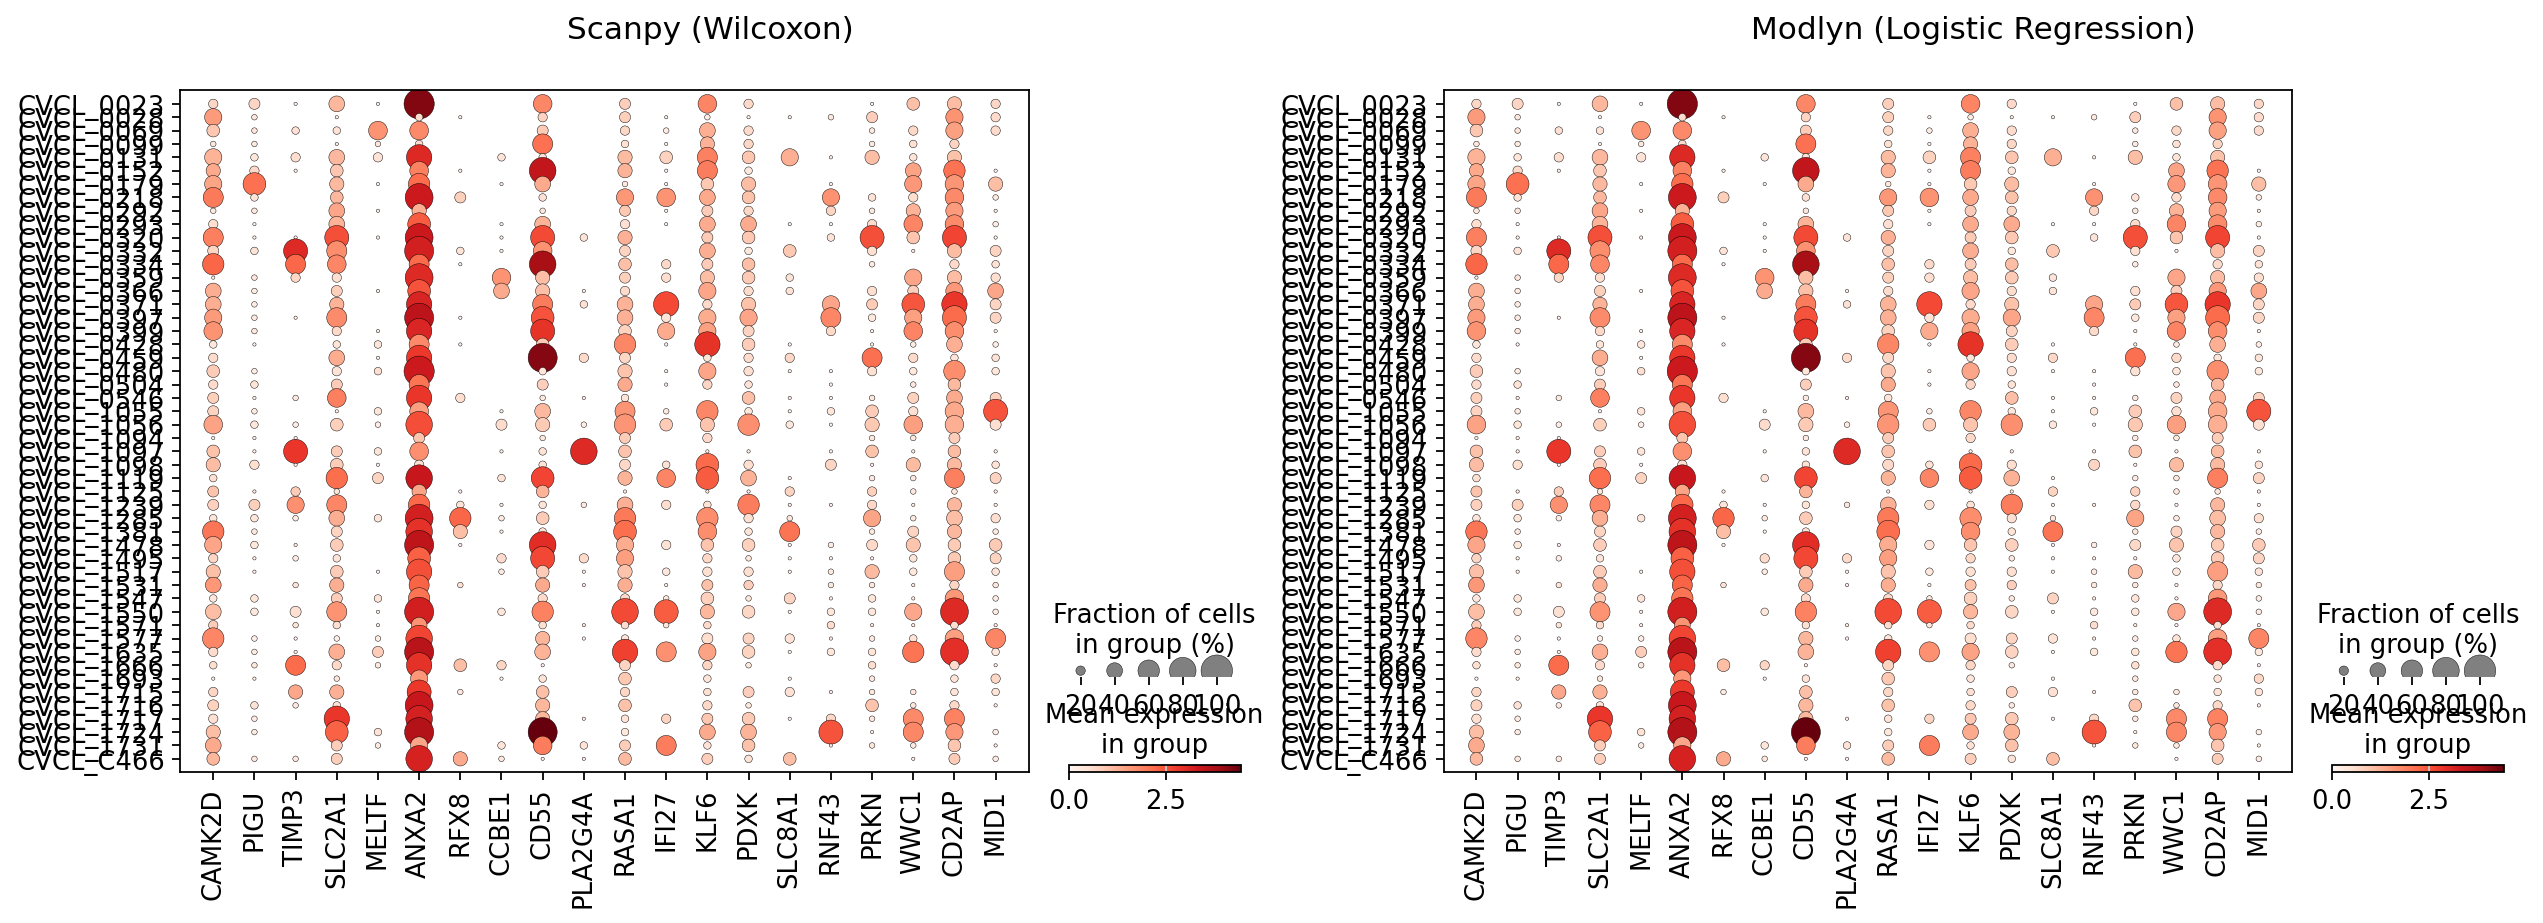

In [19]:
def plot_comparative_dotplots(adata_scanpy, modlyn_adata, scanpy_results, modlyn_results, 
                            top_n=10, figsize=(16, 6)):
    """Simple side-by-side dotplots"""
    
    # Just get top genes from scanpy results
    all_top_genes = set()
    for cell_line, df in scanpy_results.items():
        all_top_genes.update(df.head(top_n).index.tolist())
    
    # Limit to reasonable number for visualization
    plot_genes = list(all_top_genes)[:20]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Scanpy dotplot
    sc.pl.dotplot(adata_scanpy, plot_genes, groupby='cell_line', 
                  ax=ax1, show=False, dendrogram=False)
    ax1.set_title('Scanpy (Wilcoxon)')
    
    print("---")
    # Modlyn dotplot - just normalize the same way
    modlyn_adata_simple = modlyn_adata.copy()
    modlyn_adata_simple.X = modlyn_adata_simple.X.compute()
    
    if hasattr(modlyn_adata_simple.X, 'toarray'):
        modlyn_adata_simple.X = modlyn_adata_simple.X.toarray()
    sc.pp.normalize_total(modlyn_adata_simple, target_sum=1e4)
    sc.pp.log1p(modlyn_adata_simple)
    
    sc.pl.dotplot(modlyn_adata_simple, plot_genes, groupby='cell_line', 
                  ax=ax2, show=False, dendrogram=False)
    ax2.set_title('Modlyn (Logistic Regression)')
    
    plt.tight_layout()
    return fig

fig = plot_comparative_dotplots(adata_scanpy, modlyn_adata, scanpy_results, modlyn_results, top_n=10)

In [22]:
def calculate_rank_correlations(scanpy_results, modlyn_results, top_n=20):
    """Simple rank correlation calculation"""
    
    correlations = {}
    
    for cell_line in scanpy_results.keys():
        if cell_line in modlyn_results:
            # Get top genes from each method
            scanpy_genes = scanpy_results[cell_line].head(top_n).index.tolist()
            modlyn_genes = modlyn_results[cell_line].head(top_n).index.tolist()
            
            # Find common genes
            common_genes = list(set(scanpy_genes) & set(modlyn_genes))
            
            if len(common_genes) > 3:  # Need minimum overlap
                # Get ranks for common genes
                scanpy_ranks = [scanpy_genes.index(gene) for gene in common_genes]
                modlyn_ranks = [modlyn_genes.index(gene) for gene in common_genes]
                
                # Calculate correlation
                spearman_r, _ = spearmanr(scanpy_ranks, modlyn_ranks)
                
                correlations[cell_line] = {
                    'n_common': len(common_genes),
                    'correlation': spearman_r,
                    'scanpy_ranks': scanpy_ranks,
                    'modlyn_ranks': modlyn_ranks
                }
    
    return correlations

def plot_rank_correlations(correlations):
    """Simple correlation plot"""
    
    if not correlations:
        print("No correlations to plot - no overlapping genes found")
        return None
    
    n_lines = len(correlations)
    n_cols = min(4, n_lines)
    n_rows = max(1, (n_lines + n_cols - 1) // n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows))
    if n_lines == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if n_cols > 1 else [axes]
    else:
        axes = axes.flatten()
    
    for i, (cell_line, data) in enumerate(correlations.items()):
        ax = axes[i]
        
        ax.scatter(data['scanpy_ranks'], data['modlyn_ranks'], alpha=0.7)
        ax.set_title(f'{cell_line}\nr = {data["correlation"]:.2f}')
        ax.set_xlabel('Scanpy Rank')
        ax.set_ylabel('Modlyn Rank')
        
        # Add diagonal line
        max_rank = max(max(data['scanpy_ranks']), max(data['modlyn_ranks']))
        ax.plot([0, max_rank], [0, max_rank], 'r--', alpha=0.5)
    
    # Hide extra subplots
    for i in range(len(correlations), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    return fig

def print_summary_statistics(correlations):
    """Simple summary"""
    
    print("SCANPY vs MODLYN COMPARISON")
    print("="*40)
    
    correlations_list = [c['correlation'] for c in correlations.values() if not np.isnan(c['correlation'])]
    n_common_list = [c['n_common'] for c in correlations.values()]
    
    print(f"Cell lines analyzed: {len(correlations)}")
    print(f"Average overlap: {np.mean(n_common_list):.1f} genes")
    print(f"Average correlation: {np.mean(correlations_list):.3f}")
    
    print("\nBy cell line:")
    for cell_line, data in correlations.items():
        print(f"{cell_line}: {data['n_common']} genes, r = {data['correlation']:.3f}")

# Run analysis
correlations = calculate_rank_correlations(scanpy_results, modlyn_results, top_n=20)
fig_corr = plot_rank_correlations(correlations)
plt.show()
print_summary_statistics(correlations)

No correlations to plot - no overlapping genes found
SCANPY vs MODLYN COMPARISON
Cell lines analyzed: 0
Average overlap: nan genes
Average correlation: nan

By cell line:


/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/conda/envs/lamin_env/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# =============================================================================
# STEP 7: Save Results
# =============================================================================

# Save the clean subset for future use
print("\nSaving clean subset...")
adata.write_h5ad('clean_subset_100k.h5ad')

# Save results
import pickle
with open('comparison_results.pkl', 'wb') as f:
    pickle.dump({
        'scanpy_results': scanpy_results,
        'modlyn_results': modlyn_results,
        'correlations': correlations
    }, f)

print("Analysis complete! Files saved:")
print("- clean_subset_100k.h5ad")
print("- comparison_results.pkl") 
print("- comparative_dotplots.png")
print("- rank_correlations.png")


Saving clean subset...
